## Importing Potosnail library, check out it's offical repo here: https://github.com/spe301/Potosnail

In [1]:
from potosnail import MachineLearning, DataHelper, Evaluater, DeepLearning
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#class instantiations 
ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()
dl = DeepLearning()

def CBA(model, X, y, rate, total_cost, discount):
    '''calculates the potential revenue with and of using the model to make decisions'''
    cm = confusion_matrix(y, model.predict(X))
    tn = cm[0][0] * rate
    fp = cm[0][1] * (rate-discount)
    fn = cm[1][0] * (total_cost) * -1
    tp = cm[1][1] * (rate-discount)
    ml = tn + fp + fn + tp
    n = (cm[0][0] + cm[0][1])*rate
    p = (cm[1][0] + cm[1][1])*total_cost*-1
    no = n + p
    return 'With this model: ${}, without ml: ${}'.format(ml, no)

def PipeIt(scaler, model, X, y):
    '''an sklearn pipeline that returns the train and test score with scaled data'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
    return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))

In [2]:
df = pd.read_csv(r'C:\Users\aacjp\OneDrive\Desktop\data\tables\ChurnData_ForML.csv')

HO = dh.HoldOut(df) 
df = HO[0].drop(['Unnamed: 0'], axis='columns') #training data
val_df = HO[1].drop(['Unnamed: 0'], axis='columns') #validation data

In [3]:
X = df.drop(['churn'], axis='columns')
y = df['churn']
ml.CompareModels(df, 'churn', 'classification') #compares vanilla sklearn models against eachother

[13:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.905291,0.881333
1,NB,0.855047,0.849333
2,DT,1.000000,0.920000
3,RF,1.000000,0.953333
4,AB,0.896398,0.873333
5,GB,0.975989,0.949333
6,XGB,1.000000,0.950667
7,Log,0.861272,0.852000
8,SVM,0.857715,0.852000


# Step 1: picking a model to start with
my CompareClassifiers function trains a vanilla model of each type of classifier and returns the train and test accuracy. I'm gonna go with XGB because test accuracy is high and very close to train accuracy.

## Recall is our metric
The reason for this is because False Negatives will be more costly than False Positives. Let's say we want to offer a 25% discount, about 14 dollars given that the average customer is billed 56 dollars a month, for a customer that is predicted to churn to keep them. In this situation a false negative would cost us 56 dollars plus the cost of aquiring a new customer. The average cost of acquisition is 350 dollars for a cellphone company! However a false positive would only cost us 14 dollars because of the unnessecary discount.

In [4]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, df, 'churn', metric='recall')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    6.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.2s finished


[13:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
ev.ScoreModel(clf, X, y)

[13:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9848821698532682, Validation: 0.9413333333333334'

[15:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


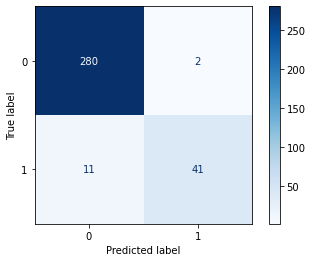

In [154]:
fitted_model = clf.fit(X, y)
Xval = val_df.drop(['churn'], axis='columns')
yval = val_df['churn']
ev.BuildConfusion(clf, Xval, yval, cmap='Blues')

In [155]:
ev.AUC(clf, Xval, yval)

0.890684669939989

In [9]:
from sklearn.metrics import confusion_matrix

def CBA(model, X, y, rate, total_cost, discount):
    cm = confusion_matrix(y, model.predict(X))
    tn = cm[0][0] * rate
    fp = cm[0][1] * (rate-discount)
    fn = cm[1][0] * (total_cost) * -1
    tp = cm[1][1] * (rate-discount)
    ml = tn + fp + fn + tp
    n = (cm[0][0] + cm[0][1])*rate
    p = (cm[1][0] + cm[1][1])*total_cost*-1
    no = n + p
    return 'With this model: ${}, without ml: ${}'.format(ml, no)

In [10]:
CBA(clf, Xval, yval, 56, 350, 14)

'With this model: $14812, without ml: $-2408'

# Step 2: normalize the data
Accuracy imporved more from MinMaxScaling but validation recall and AUC dropped significantly. I ended up using standard scaler instead.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

def PipeIt(scaler, model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
    return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))

In [12]:
scaler = StandardScaler()
PipeIt(scaler, clf, X, y)

[13:04:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9817696754112939, Validation: 0.952'

In [13]:
scaler = MinMaxScaler()
PipeIt(scaler, clf, X, y)

[13:04:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9835482436638506, Validation: 0.9413333333333334'

In [14]:
ml = MachineLearning()

X2 = StandardScaler().fit(X).transform(X)
Xval2 = StandardScaler().fit(Xval).transform(Xval)
df3 = pd.DataFrame(X2)
df3['churn'] = list(y)
ml.CompareModels(df3, 'churn', 'classification')

[13:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.902623,0.900000
1,NB,0.859938,0.865333
2,DT,1.000000,0.894667
3,RF,1.000000,0.954667
4,AB,0.894175,0.889333
5,GB,0.975100,0.941333
6,XGB,1.000000,0.956000
7,Log,0.863940,0.890667
8,SVM,0.943975,0.921333


In [15]:
parameters =  {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf2 = ml.Optimize(XGBClassifier(), parameters, df3, 'churn')
clf2

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


[13:04:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
ev.ScoreModel(clf, X2, y)

[13:04:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9848821698532682, Validation: 0.952'

[13:04:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


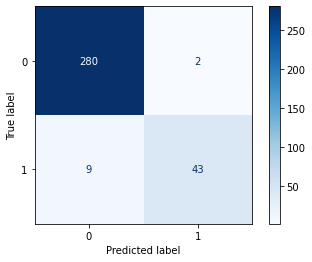

In [17]:
model2 = clf2.fit(X2, y)
ev.BuildConfusion(model2, Xval2, yval, cmap='Blues')

In [18]:
CBA(clf, Xval2, yval, 56, 350, 14)

'With this model: $13664, without ml: $-2408'

In [19]:
ev.AUC(clf, Xval2, yval)

0.8942307692307692

## Step 3: fixing class imbalance with SMOTE sampling

Smote, synthetic minority oversampling, handles class imbalance that generate synthetic datapoints of the minority class. this way the model isn't rewarded for simply labeling everything the majority class
* In addition to SMOTE, you can set metrics to 'recall', which I already did in cell 4

In [20]:
X3, y3 = dh.SmoteIt(X2, y)

In [21]:
df3 = pd.DataFrame(X3)
df3['churn'] = y3
ml.CompareModels(df3, 'churn', 'classification')

[13:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.929128,0.899533
1,NB,0.736501,0.711838
2,DT,1.000000,0.914330
3,RF,1.000000,0.954050
4,AB,0.895898,0.877726
5,GB,0.964434,0.949377
6,XGB,1.000000,0.972741
7,Log,0.792316,0.780374
8,SVM,0.935099,0.909657


In [22]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf3 = ml.Optimize(XGBClassifier(), parameters, df3, 'churn')
clf3

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.6s finished


[13:04:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
ev.ScoreModel(clf3, X3, y3)

[13:05:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 1.0, Validation: 0.9649532710280374'

[13:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


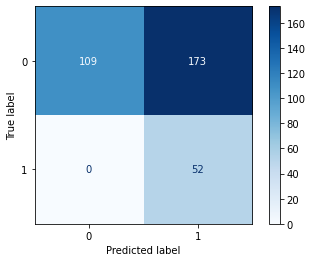

In [24]:
Xval3 = pd.DataFrame(Xval2)
ev.BuildConfusion(clf3.fit(X3, y3), Xval2, yval, cmap='Blues')

In [25]:
CBA(clf3, Xval2, yval, 56, 350, 14)

'With this model: $15554, without ml: $-2408'

In [26]:
ev.AUC(clf3, Xval2, yval)

0.6932624113475176

In [27]:
lst = ['international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 '%night',
 '%eve',
 'avg duration',
 'Midwest',
 'Noncontinental',
 'Northeast',
 'Northwest',
 'Southeast',
 'Southwest']

df3.columns = lst + ['churn']
Xval3 = pd.DataFrame(Xval2)
Xval3.columns = lst
df3.head()

,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,%night,%eve,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southeast,Southwest,churn
0,-0.330299,1.615210,1.963794,0.259905,-1.909081,0.260281,-0.060677,-0.137927,-0.059801,0.349850,...,0.654298,0.860396,-1.054852,-0.569778,-0.179883,1.666457,-0.347423,-0.567724,-0.346820,0
1,-0.330299,1.615210,0.941186,-2.110027,-0.106977,-2.110302,-0.485114,-0.696700,-0.484819,0.865112,...,-0.435633,-0.224231,0.212800,1.755070,-0.179883,-0.600076,-0.347423,-0.567724,-0.346820,0
2,-0.330299,-0.619114,-0.592726,-1.374468,0.744016,-1.374418,0.969818,2.249556,0.969068,-0.175321,...,-0.980599,1.221938,1.171912,-0.569778,-0.179883,-0.600076,-0.347423,1.761420,-0.346820,0
3,-0.330299,-0.619114,-0.592726,0.331443,-1.808964,0.331495,-1.262921,1.335200,-1.262858,0.857185,...,-0.617288,2.306566,-0.569711,-0.569778,-0.179883,1.666457,-0.347423,-0.567724,-0.346820,0
4,-0.330299,-0.619114,-0.592726,1.945638,-2.810133,1.945693,-0.654889,2.249556,-0.654362,1.166342,...,0.109332,3.210421,-1.210326,-0.569778,-0.179883,-0.600076,-0.347423,-0.567724,2.883343,1


## Step 4: Time for some Feature Engineering
* I will test out 3 different feature combos
* I will test between using 10, 16, and 19 features

In [28]:
Xval3.head()

,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,customer service calls,%night,%eve,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southeast,Southwest
0,-0.302495,-0.611952,-0.583096,0.983386,-0.102460,0.983645,-0.069201,0.801857,-0.068519,0.757941,...,0.427437,-0.679910,0.991336,-0.689232,1.996265,-0.184542,-0.598100,-0.363598,-0.593487,-0.379257
1,-0.302495,1.634114,1.541759,0.822055,-1.167352,0.822203,-0.325666,0.384764,-0.326485,1.607360,...,-0.370127,0.821511,0.618888,-0.926829,1.996265,-0.184542,-0.598100,-0.363598,-0.593487,-0.379257
2,-0.302495,1.634114,0.809051,2.040381,2.269344,2.040652,0.449602,0.894544,0.449717,0.402234,...,-0.370127,-2.369009,0.432664,-0.703876,-0.500935,-0.184542,-0.598100,-0.363598,1.684957,-0.379257
3,-0.302495,1.634114,2.347738,-0.982254,-0.199269,-0.982018,0.860729,-1.190922,0.859699,0.025147,...,-1.167690,1.572222,-1.429576,-0.191324,-0.500935,-0.184542,1.671961,-0.363598,-0.593487,-0.379257
4,-0.302495,-0.611952,-0.583096,-1.610887,0.236369,-1.611423,1.181799,-0.171361,1.182157,0.102897,...,-0.370127,-0.867588,0.246440,-0.256139,1.996265,-0.184542,-0.598100,-0.363598,-0.593487,-0.379257


In [44]:
X4 = pd.DataFrame(X3)
X4.columns = lst
sample1 = X4.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sv1 = Xval3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sample2 = X4.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sv2 = Xval3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sample3 = X4.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')
sv3 = Xval3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')

## using 16 features...

In [45]:
ml.CompareModels(df3, 'churn', 'classification')

[13:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.926272,0.899533
1,NB,0.737799,0.732866
2,DT,1.000000,0.929907
3,RF,1.000000,0.950935
4,AB,0.895379,0.874611
5,GB,0.965732,0.943925
6,XGB,1.000000,0.967290
7,Log,0.787902,0.791277
8,SVM,0.934060,0.921340


In [54]:
df4 = sample1
df4['churn'] = y3
clf4 = ml.Optimize(XGBClassifier(), parameters, df4, 'churn')
clf4

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.5s finished


[13:27:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

[13:31:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.7155619203491544
Training: 0.9987019730010385, Validation: 0.9657320872274143


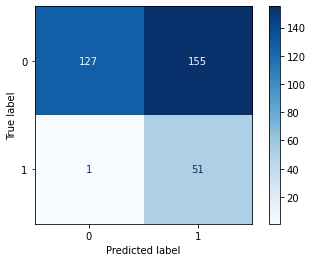

In [55]:
score = ev.ScoreModel(clf, sample1.drop(['churn'], axis='columns'), y3)
fit = clf.fit(sample1.drop(['churn'], axis='columns'), y3)
ev.BuildConfusion(fit, sv1, yval, cmap='Blues')
print('AUC: {}'.format(ev.AUC(clf, sv1, yval)))
print(score)

In [56]:
CBA(clf4, sv1, yval, 56, 350, 14)

'With this model: $15540, without ml: $-2408'

## using 19 features...

In [65]:
df5 = sample2
df5['churn'] = y3
ml.CompareModels(df5, 'churn', 'classification')

[13:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.928609,0.895639
1,NB,0.773364,0.771807
2,DT,1.000000,0.926791
3,RF,1.000000,0.955607
4,AB,0.890187,0.886293
5,GB,0.963136,0.957944
6,XGB,1.000000,0.971184
7,Log,0.782451,0.793614
8,SVM,0.917705,0.906542


In [67]:
clf5 = ml.Optimize(XGBClassifier(), parameters, df5, 'churn')
clf5

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    8.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.4s finished


[13:37:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

[14:28:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training: 0.9989615784008308, Validation: 0.9758566978193146


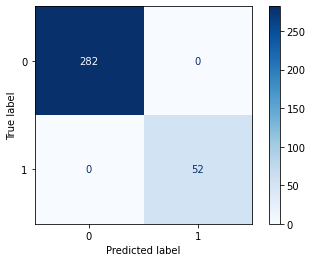

In [110]:
score = ev.ScoreModel(clf, sample2.drop(['churn'], axis='columns'), y3)
clf5.fit(sv2, yval)
print(score)
ev.BuildConfusion(clf5, sv2, yval, cmap='Blues')

## Perfect Model^^

In [111]:
CBA(clf5, sv2, yval, 56, 350, 14)

'With this model: $17976, without ml: $-2408'

## using 10 features...

In [112]:
df6 = sample3
df6['churn'] = y3
ml.CompareModels(df6, 'churn', 'classification')

[14:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.938474,0.904984
1,NB,0.801921,0.808411
2,DT,1.000000,0.924455
3,RF,1.000000,0.947819
4,AB,0.895898,0.891745
5,GB,0.962617,0.952492
6,XGB,1.000000,0.975078
7,Log,0.779076,0.784268
8,SVM,0.912773,0.907321


In [113]:
clf6 = ml.Optimize(XGBClassifier(), parameters, df6, 'churn')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    7.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.2s finished


[14:29:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training: 0.9994807892004154, Validation: 0.9672897196261683


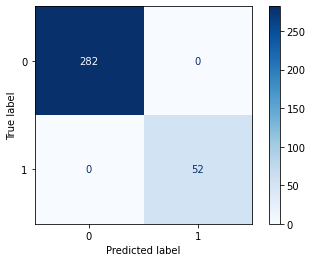

In [119]:
score = ev.ScoreModel(clf6, sample3.drop(['churn'], axis='columns'), y3)
clf6.fit(sv3, yval)
print(score)
ev.BuildConfusion(clf6, sv3, yval, cmap='Blues')

## Perfect model^^

In [120]:
CBA(clf6, sv3, yval, 56, 350, 42)

'With this model: $16520, without ml: $-2408'

In [121]:
ev.AUC(clf6, sv3, yval)

1.0

[14:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


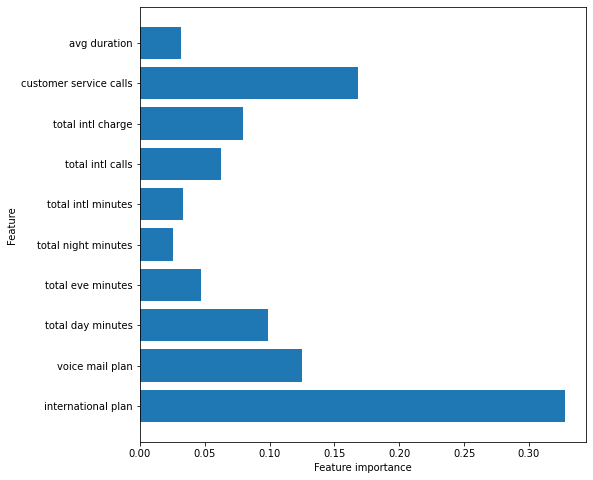

In [122]:
ev.GetImportance(clf6, sample3.drop(['churn'], axis='columns'), y3)

# Giving Deep Learning a shot!

In [127]:
train_data = np.array(sample3.drop(['churn'], axis='columns'))
test_data = np.array(sv3)
train_labels = dl.MulticlassOutput(np.array(y3))
test_lables = dl.MulticlassOutput(np.array(yval))

In [141]:
early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
model = dl.FastNN('classification', 'binary_crossentropy', output_dim=2)
history = model.fit(train_data, train_labels, batch_size=32, epochs=150, validation_split=0.2, callbacks=early_stopping)

Epoch 1/150
129/129 [==============================] - 1s 2ms/step - loss: 0.6095 - accuracy: 0.6818 - val_loss: 0.4676 - val_accuracy: 0.8307
Epoch 2/150
129/129 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8542 - val_loss: 0.4613 - val_accuracy: 0.8366
Epoch 3/150
129/129 [==============================] - 0s 1ms/step - loss: 0.3151 - accuracy: 0.8794 - val_loss: 0.4459 - val_accuracy: 0.8327
Epoch 4/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2861 - accuracy: 0.8936 - val_loss: 0.4028 - val_accuracy: 0.8463
Epoch 5/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2627 - accuracy: 0.9071 - val_loss: 0.3805 - val_accuracy: 0.8492
Epoch 6/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2483 - accuracy: 0.9186 - val_loss: 0.3662 - val_accuracy: 0.8463
Epoch 7/150
129/129 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.9186 - val_loss: 0.3850 - val_accuracy: 0.8434

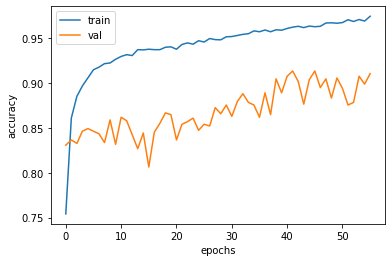

In [142]:
ev.ViewAccuracy(history, len(history.history['loss']))

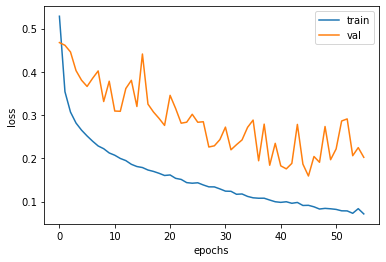

In [143]:
ev.ViewLoss(history, len(history.history['loss']))

<AxesSubplot:xlabel='Predict', ylabel='True'>

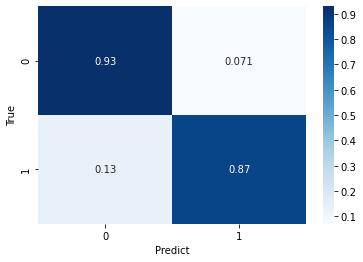

In [146]:
ev.BuildConfusionDL(model, test_data, test_lables, cmap='Blues')

Our training data has 87% recall and 93% precision, not too bad :)

here's the repo for this notebook: https://github.com/spe301/dsc-phase-3-project